In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
%cd /content/drive/MyDrive/DL-Projects/Potato-Disease

/content/drive/MyDrive/DL-Projects/Potato-Disease


In [97]:
%pwd

'/content/drive/MyDrive/DL-Projects/Potato-Disease'

In [98]:
!ls

Data  models  Training


In [99]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [100]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=70


##Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [101]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/DL-Projects/Potato-Disease/Data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [102]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [103]:
len(dataset)
#68*32 -> batch size

68

In [104]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


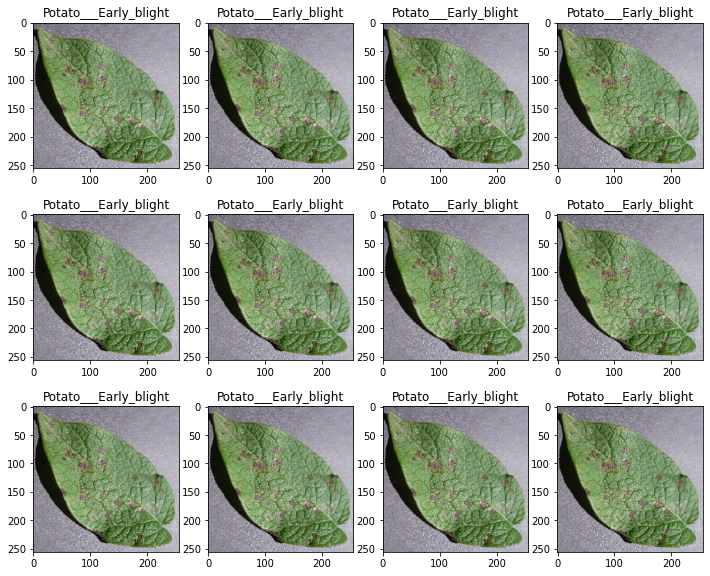

In [105]:
plt.figure(figsize=(12,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])

In [106]:
# train_size = 0.8
# len(dataset)*train_size

In [107]:
# train_ds = dataset.take(54)
# len(train_ds)

In [108]:
# test_valid_ds = dataset.skip(54)
# len(test_valid_ds)

In [109]:
# val_size=0.1
# len(dataset)*val_size

In [110]:
# val_ds = test_valid_ds.take(6)
# len(val_ds)

In [111]:
# test_ds = test_valid_ds.skip(6)
# len(test_ds)

In [112]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [113]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [114]:
print(f"trainin size : {len(train_ds)}, validation size : {len(val_ds)}, test_size : {len(test_ds)} ",)

trainin size : 54, validation size : 6, test_size : 8 


In [115]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

##Building the Model

###Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [116]:
#Resize and Rescale image
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

###Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [117]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

####Applying Data Augmentation to Train Dataset

In [118]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

###Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [119]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    ])

model.build(input_shape=input_shape)

In [120]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (32, 60, 60, 64)        

In [121]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [122]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/70
54/54 [==============================] - 15s 252ms/step - loss: 0.8569 - accuracy: 0.5903 - val_loss: 0.6923 - val_accuracy: 0.7083
Epoch 2/70
54/54 [==============================] - 12s 229ms/step - loss: 0.6129 - accuracy: 0.7367 - val_loss: 0.4621 - val_accuracy: 0.7708
Epoch 3/70
54/54 [==============================] - 12s 229ms/step - loss: 0.3788 - accuracy: 0.8374 - val_loss: 0.3769 - val_accuracy: 0.8125
Epoch 4/70
54/54 [==============================] - 12s 229ms/step - loss: 0.2721 - accuracy: 0.8924 - val_loss: 0.2757 - val_accuracy: 0.8750
Epoch 5/70
54/54 [==============================] - 12s 229ms/step - loss: 0.2489 - accuracy: 0.9057 - val_loss: 0.3071 - val_accuracy: 0.8438
Epoch 6/70
54/54 [==============================] - 12s 230ms/step - loss: 0.1903 - accuracy: 0.9248 - val_loss: 0.1865 - val_accuracy: 0.9115
Epoch 7/70
54/54 [==============================] - 12s 229ms/step - loss: 0.2147 - accuracy: 0.9178 - val_loss: 0.2594 - val_accuracy: 0.9062

In [123]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 12ms/step - loss: 0.0628 - accuracy: 0.9766


In [124]:
scores

[0.06276366859674454, 0.9765625]

In [125]:
history.params

{'verbose': 1, 'epochs': 70, 'steps': 54}

In [126]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [127]:
type(history.history['loss'])

list

In [128]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-a3322b02-c3d1-7a73-9223-16c350dab3f1)


In [129]:
history.history['accuracy'][:5]

[0.5902777910232544,
 0.7366898059844971,
 0.8373842835426331,
 0.8923611044883728,
 0.9056712985038757]

In [130]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8569426536560059,
 0.6129368543624878,
 0.37876054644584656,
 0.2721298635005951,
 0.24891716241836548]

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

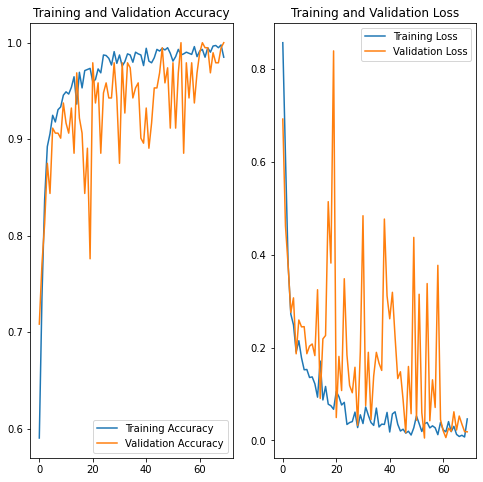

In [132]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 120ms/step
predicted label: Potato___Late_blight


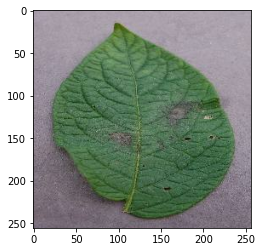

In [133]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [134]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


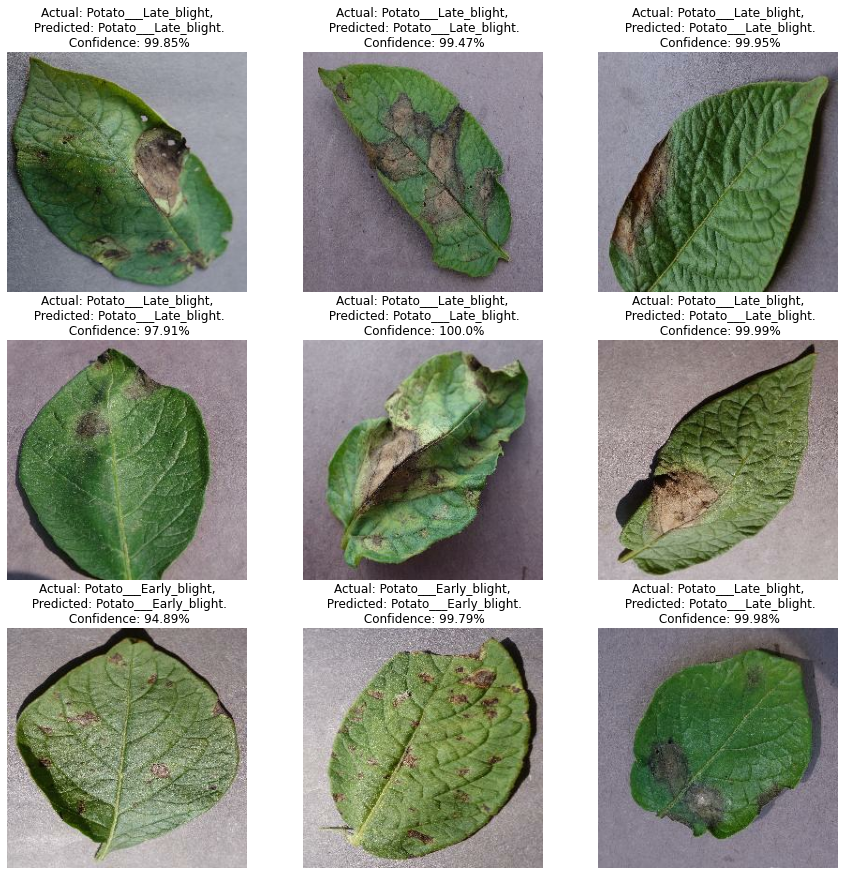

In [135]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [136]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/DL-Projects/Potato-Disease/models") + [0]])+1
model.save(f"/content/drive/MyDrive/DL-Projects/Potato-Disease/models/{model_version}")